In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [46]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, LSTM, Dropout

In [47]:
weather = pd.read_csv('austin_weather.csv')
weather.head()

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,


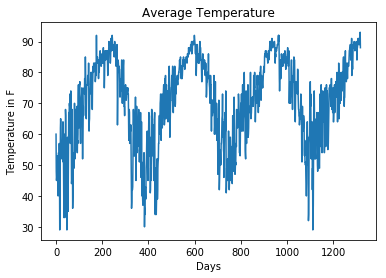

In [48]:
plt.plot(weather.TempAvgF)
plt.ylabel('Temperature in F')
plt.xlabel('Days')
plt.title('Average Temperature')
plt.show()

In [49]:
#save temp as a float and convert to column
avg_temp = weather.TempAvgF.values.astype('float32')
avg_temp = avg_temp.reshape(len(avg_temp), 1)

In [50]:
#Scale between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
avg_temp = scaler.fit_transform(avg_temp)

In [51]:
#split the data between training and testing
train_split = 0.75

train_size = int(len(avg_temp) * train_split)
test_size = len(avg_temp) - train_size

X_train, X_test = avg_temp[0:train_size,:], avg_temp[train_size:,:]

print(len(X_train), len(X_test))

989 330


In [52]:
# create a dataset matrix
def create_dataset(data, lookback):
    X_data, y_data = [], []
    for i in range(len(data)-lookback-1):
        a = data[i:(i+lookback), 0]
        X_data.append(a)
        y_data.append(data[i + lookback, 0])
    return np.array(X_data), np.array(y_data)

In [53]:
lookback = 1
X_train, y_train = create_dataset(X_train, lookback)
X_test, y_test = create_dataset(X_test, lookback)
print(X_train[:10], y_train[:10])

[[0.484375]
 [0.296875]
 [0.25    ]
 [0.265625]
 [0.328125]
 [0.296875]
 [0.375   ]
 [0.34375 ]
 [0.328125]
 [0.171875]] [0.296875 0.25     0.265625 0.328125 0.296875 0.375    0.34375  0.328125
 0.171875 0.265625]


In [34]:
#reshape the data to be 3 dimensional in the form [num of samples, num of timesteps, num of features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(987, 1, 1) (987,) (328, 1, 1) (328,)


In [41]:
#the LSTM model
model = Sequential()

model.add(LSTM(256, input_shape = (X_train.shape[1], 1), return_sequences = True))
model.add(Dropout(0.2))


model.add(Dense(128))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'relu'))

model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 256)            264192    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 1, 128)            32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              129       
Total params: 297,217
Trainable params: 297,217
Non-trainable params: 0
_________________________________________________________________


In [42]:
h = model.fit(X_train, y_train, batch_size= 351, epochs=5)

Train on 987 samples
Epoch 1/5
987/987 [==============================] - 10s 10ms/sample - loss: 0.4217 - accuracy: 0.0019
Epoch 2/5
987/987 [==============================] - 0s 291us/sample - loss: 0.2844 - accuracy: 0.0019
Epoch 3/5
987/987 [==============================] - 0s 392us/sample - loss: 0.1691 - accuracy: 0.0021
Epoch 4/5
987/987 [==============================] - 1s 559us/sample - loss: 0.0927 - accuracy: 0.0015
Epoch 5/5
987/987 [==============================] - 0s 404us/sample - loss: 0.0691 - accuracy: 3.9374e-04


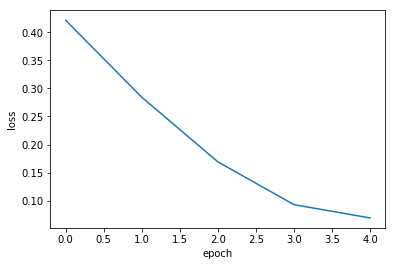

In [43]:
#graph the loss, just to visualize 
plt.plot(h.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

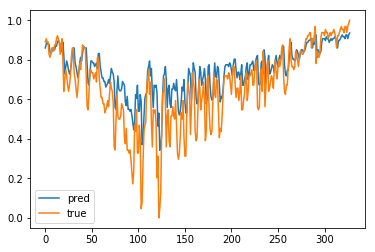

In [44]:
# graph the predicitons vs the actual data. Visualization helps!
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1)
plt.plot(y_pred, label = 'pred')
plt.plot(y_test, label = 'true')
plt.legend()
plt.show()